In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle as astropy_ls

import matplotlib 
matplotlib.rc('xtick', labelsize=36) 
matplotlib.rc('ytick', labelsize=36) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)


In [15]:
import pandas as pd

# File path to the TSV file
file_path = './holczer_catalog_wFlags.tsv'

# Define custom column header names
custom_column_headers = ['KOI', 'N', 't_lin', 'O-C', 'e_O-C', 'f_O-C', 'f_TDV', 'f_TPV']

# Load the TSV file into a DataFrame
holczer_catalog = pd.read_csv(file_path, delimiter='\t', skiprows=42, names=custom_column_headers)

# Filter the DataFrame to keep rows that do not contain '*'
mask = holczer_catalog[['f_O-C', 'f_TDV', 'f_TPV']].isin(['*']).any(axis=1)
holczer_catalog_noFlags = holczer_catalog.loc[~mask].copy()


holczer_catalog_noFlags = holczer_catalog_noFlags.drop(columns=['f_O-C'])
holczer_catalog_noFlags = holczer_catalog_noFlags.drop(columns=['f_TDV'])
holczer_catalog_noFlags = holczer_catalog_noFlags.drop(columns=['f_TPV'])
#holczer_catalog_noFlags = holczer_catalog_noFlags.drop(columns=['t_lin'])

# Calculate 'times' and 'times_err' columns
holczer_catalog_noFlags['times'] = holczer_catalog_noFlags['t_lin'] + (holczer_catalog_noFlags['O-C'] / (24. * 60.)) # convert to days
holczer_catalog_noFlags['times_err'] = holczer_catalog_noFlags['e_O-C'] / (24. * 60.) # convert to days

holczer_catalog_noFlags = holczer_catalog_noFlags.drop(columns=['t_lin'])

#holczer_catalog_noFlags.to_csv('holczer_catalog_v1.csv')
holczer_catalog_noFlags




,KOI,N,O-C,e_O-C,times,times_err
0,1.01,0,-0.050,0.09,55.763302,0.000063
1,1.01,1,0.077,0.09,58.234003,0.000063
2,1.01,2,-0.037,0.09,60.704537,0.000063
3,1.01,4,-0.271,0.09,65.645602,0.000063
4,1.01,5,-0.003,0.09,68.116402,0.000063
...,...,...,...,...,...,...
295182,5970.01,4,89.000,50.00,734.159666,0.034722
295183,5970.01,5,-8.000,30.00,885.665217,0.020833
295184,5970.01,6,7.000,20.00,1037.248548,0.013889
295185,5970.01,7,2.000,40.00,1188.817990,0.027778


In [16]:
# Create a list of DataFrames, where each DataFrame represents a unique value in the 'KOI' column
holczer_catalog_by_koi = [group_df for _, group_df in holczer_catalog_noFlags.groupby('KOI')]


holczer_catalog_by_koi



[      KOI    N    O-C  e_O-C        times  times_err
 0    1.01    0 -0.050   0.09    55.763302   0.000063
 1    1.01    1  0.077   0.09    58.234003   0.000063
 2    1.01    2 -0.037   0.09    60.704537   0.000063
 3    1.01    4 -0.271   0.09    65.645602   0.000063
 4    1.01    5 -0.003   0.09    68.116402   0.000063
 ..    ...  ...    ...    ...          ...        ...
 427  1.01  588  0.122   0.09  1508.484087   0.000063
 428  1.01  589 -0.050   0.09  1510.954580   0.000063
 429  1.01  590  0.111   0.09  1513.425306   0.000063
 430  1.01  593  0.142   0.09  1520.837168   0.000063
 431  1.01  594 -0.043   0.08  1523.307652   0.000056
 
 [430 rows x 6 columns],
        KOI    N   O-C  e_O-C        times  times_err
 432   2.01    0 -0.26    0.2    54.358289   0.000139
 433   2.01    1  0.26    0.2    56.563386   0.000139
 434   2.01    2  0.27    0.2    58.768129   0.000139
 435   2.01    3  0.19    0.2    60.972808   0.000139
 436   2.01    5  0.22    0.2    65.382300   0.000139
 

To this end, we first extract the
quoted TTVs from H+16 and divide them by their quoted
uncertainties. We next measure the RMS of this list using a
median-based robust measure, specifically 1.4826 multiplied
by the median absolute deviation (MAD). We then remove
any transit times for which the quoted TTV normalised by
the quoted uncertainty exceeds 10 times this robust RMS
value. The idea here is to reject points which are dispersed an
order-of-magnitude more than the observed scatter. We also
remove any transit times for which the H+16 reported uncertainty is > 3 times greater than the median uncertainty of
that KOI, typically associated with partial transits of poorer
data quality.

In [17]:
holczer_catalog_by_koi_outlier_removed = []
for a_koi in holczer_catalog_by_koi:
    # Calculate O-C_norm by dividing O-C by e_O-C
    a_koi['O-C_norm'] = a_koi['O-C'] / a_koi['e_O-C']

    # Calculate the robust RMS (root mean square) using the median absolute deviation (MAD)
    robust_rms = 1.4826 * np.median(np.abs(a_koi['O-C'] - np.median(a_koi['O-C'])))

    # Create a new column called 'RMS' with the robust RMS value
    a_koi['RMS'] = robust_rms

    # Remove rows where O-C_norm exceeds 10 times the robust RMS value
    a_koi = a_koi[np.abs(a_koi['O-C_norm']) <= 10 * robust_rms]
    
    
    # Remove rows where e_O-C is > 3 times greater than the median of all e_O-C values
    median_e_O_C = np.median(a_koi['e_O-C'])
    a_koi = a_koi[a_koi['e_O-C'] <= 3 * median_e_O_C]
    
    holczer_catalog_by_koi_outlier_removed.append(a_koi)
    
holczer_catalog_by_koi_outlier_removed



[      KOI    N    O-C  e_O-C        times  times_err  O-C_norm       RMS
 0    1.01    0 -0.050   0.09    55.763302   0.000063 -0.555556  0.094145
 1    1.01    1  0.077   0.09    58.234003   0.000063  0.855556  0.094145
 2    1.01    2 -0.037   0.09    60.704537   0.000063 -0.411111  0.094145
 4    1.01    5 -0.003   0.09    68.116402   0.000063 -0.033333  0.094145
 5    1.01    6  0.061   0.09    70.587059   0.000063  0.677778  0.094145
 ..    ...  ...    ...    ...          ...        ...       ...       ...
 420  1.01  545  0.033   0.09  1402.247650   0.000063  0.366667  0.094145
 424  1.01  585  0.013   0.08  1501.072171   0.000056  0.162500  0.094145
 425  1.01  586 -0.069   0.09  1503.542727   0.000063 -0.766667  0.094145
 428  1.01  589 -0.050   0.09  1510.954580   0.000063 -0.555556  0.094145
 431  1.01  594 -0.043   0.08  1523.307652   0.000056 -0.537500  0.094145
 
 [260 rows x 8 columns],
        KOI    N   O-C  e_O-C        times  times_err  O-C_norm       RMS
 432   2.01

In [18]:
def get_times_null_model(epochs, T0, P): 
    return T0 + P*epochs



def solve_null_model(epochs, times, times_err):
    # Constructing the design matrix A
    A = np.column_stack([
        np.ones_like(epochs),
        epochs
    ])

    # Constructing the weight matrix W using times_err
    W = np.diag(1.0 / times_err**2.)

    # Constructing the observed times vector y
    y = times

    # Calculating the parameters using np.linalg.solve
    parameters = np.linalg.solve(A.T @ W @ A, A.T @ W @ y)

    T0_fit, P_fit = parameters

    return T0_fit, P_fit

In [19]:
def get_times_ttv_model(epochs, T0, P, P_ttv, alpha_ttv, beta_ttv): 
    return T0 + P * epochs + alpha_ttv * np.sin((2 * np.pi * epochs / P_ttv)) + beta_ttv * np.cos((2 * np.pi * epochs / P_ttv))

def solve_ttv_model(epochs, times, times_err, P_ttv):
    # Constructing the design matrix A
    A = np.column_stack([
        np.ones_like(epochs),
        epochs,
        np.sin(2 * np.pi * epochs / P_ttv),
        np.cos(2 * np.pi * epochs / P_ttv)
    ])
    

    # Constructing the weight matrix W using times_err
    W = np.diag(1.0 / times_err**2.)

    # Constructing the observed times vector y
    y = times
    

    # Calculating the parameters using np.linalg.solve
    parameters = np.linalg.solve(A.T @ W @ A, A.T @ W @ y)

    T0_fit, P_fit, alpha_ttv_fit, beta_ttv_fit = parameters

    return T0_fit, P_fit, P_ttv, alpha_ttv_fit, beta_ttv_fit

In [20]:
def get_chisq(observed_data, predicted_data, uncertainties):
    """
    Calculate the chi-square statistic for model evaluation.

    Parameters:
        observed_data (numpy array): Array of observed data points.
        predicted_data (numpy array): Array of model-predicted data points.
        uncertainties (numpy array): Array of uncertainties/standard deviations of the observed data.

    Returns:
        float: The chi-square statistic.
    """
    if len(observed_data) != len(predicted_data) or len(observed_data) != len(uncertainties):
        raise ValueError("All input arrays must have the same length.")

    squared_residuals = ((observed_data - predicted_data) ** 2. / (uncertainties ** 2.) )
    chi_square = np.sum(squared_residuals)

    return chi_square


def get_log_likelihood(chi_square):
    """
    Calculate the log-likelihood from the chi-square value.

    Parameters:
        chi_square (float): The chi-square value of the model.
        num_data_points (int): Number of data points (sample size).

    Returns:
        float: The log-likelihood.
    """
    log_likelihood = -0.5 * chi_square
    return log_likelihood

def get_BIC(num_params, num_data_points, log_likelihood):
    """
    Calculate the Bayesian Information Criterion (BIC).

    Parameters:
        num_params (int): Number of parameters in the model.
        num_data_points (int): Number of data points (sample size).
        log_likelihood (float): Log-likelihood of the model.

    Returns:
        float: The BIC value.
    """
    BIC = num_params * np.log(num_data_points) - 2 * log_likelihood
    return BIC



### test our LS periodogram by fitting to simulated data

In [21]:
# Model parameters
T0_true = 1.0
P_true = 100
alpha_ttv_true = 0.1
beta_ttv_true = 0.05
P_ttv_true = 4

# Number of data points
num_data_points = 50

# Generate equally spaced epochs
epochs = np.linspace(0, 50, num_data_points)

# Generate normally distributed noise with mean 0 and standard deviation (adjust as needed)
noise_mean = 0.0
noise_std = 0.05

# Generate the error array representing the uncertainty of the data points
sim_error = np.random.normal(noise_mean, noise_std, num_data_points)

# Generate noisy data points based on the model and noise
sim_data = get_times_ttv_model(epochs, T0_true, P_true, P_ttv_true, alpha_ttv_true, beta_ttv_true) + sim_error

# Now 'data_points' contains 50 data points with noise, which are normally distributed away from the model.

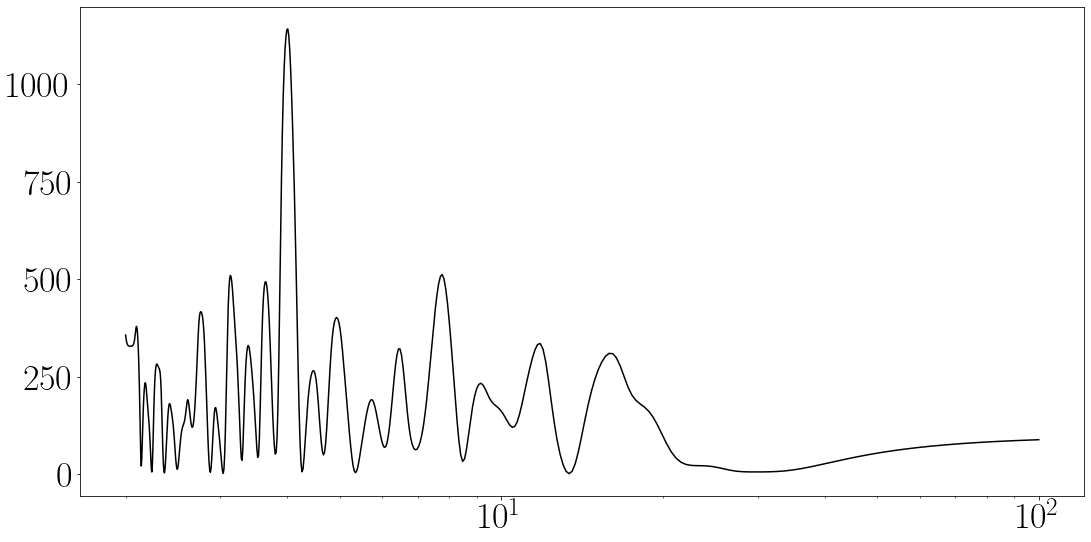

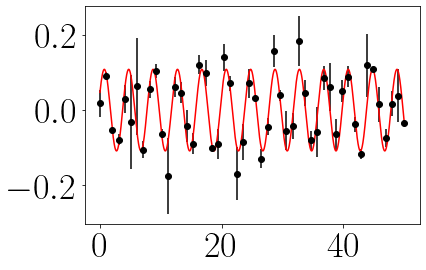

truths
1.0 100 4 0.1 0.05
LS results
(0.9970438788255834, 99.99992758539696, 4.006423123243676, 0.09750605754456497, 0.0471645321053727)
0.1118033988749895
0.10831400808114686


In [22]:
times = sim_data
times_err = sim_error




null_model  = solve_null_model(epochs, times, times_err)
times_null_model = get_times_null_model(epochs, *null_model)
null_chisq = get_chisq(times, times_null_model, times_err)

Pmin = 2
Pmax = 2*(np.max(epochs)-np.min(epochs))
fmin = 1/Pmax
fmax = 1/Pmin


fgrid = np.linspace(fmin, fmax, 10*len(times))
Pgrid = np.sort(1/fgrid)



#plt.errorbar(epochs, times-times_null_model, yerr=times_err, ls='', marker='o', color='k')
#plt.plot(epochs, times_null_model-times_null_model)



delta_chisq_grid = []
ttv_chisq_grid = []
for P_ttv in Pgrid:
    a_model  = solve_ttv_model(epochs, times, times_err, P_ttv)
    times_a_model = get_times_ttv_model(epochs, *a_model)
    a_chisq = get_chisq(times, times_a_model, times_err)
    delta_chisq = null_chisq - a_chisq
    if delta_chisq < 0:
        delta_chisq = 0.
    delta_chisq_grid.append(delta_chisq)
    ttv_chisq_grid.append(a_chisq)


plt.figure(figsize=[18,9])
plt.plot(Pgrid, delta_chisq_grid, 'k')
# Set the x-axis to be in log scale
plt.xscale('log')
plt.show()


#find max chisq ttv
max_delta_chisq = 0
min_ttv_chisq = 0
best_P_ttv = None
for ii in range(0, len(delta_chisq_grid)):
    delta_chisq = delta_chisq_grid[ii]
    ttv_chisq = ttv_chisq_grid[ii]
    period = Pgrid[ii]
    if delta_chisq > max_delta_chisq:
        max_delta_chisq = delta_chisq
        min_ttv_chisq = ttv_chisq
        best_P_ttv = period





#recalculate the max-chisq model
epochs_plot = np.arange(np.min(epochs), np.max(epochs), 0.01)
P_ttv = best_P_ttv
max_model  = solve_ttv_model(epochs, times, times_err, P_ttv) 
best_alpha_ttv, best_beta_ttv = max_model[2], max_model[3]
#times_max_model = get_times_model(epochs, *max_model)


ttvs_max_model = get_times_ttv_model(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

ttvs_input = times - get_times_null_model(epochs, *max_model[0:2])


plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
plt.plot(epochs_plot, ttvs_max_model, 'r')

plt.show()


BIC_ttv = get_BIC(min_ttv_chisq, len(times), 4)
BIC_ttv_linear = get_BIC(null_chisq, len(times), 2)

delta_BIC = BIC_ttv_linear-BIC_ttv

amplitude_ttv = np.sqrt(best_alpha_ttv**2. + best_alpha_ttv**2.)

print('truths')
print(T0_true, P_true, P_ttv_true, alpha_ttv_true, beta_ttv_true)
print('LS results')
print(max_model)
print(np.sqrt(alpha_ttv_true**2. + beta_ttv_true**2.))
print(np.sqrt(max_model[3]**2. + max_model[4]**2.))


#if delta_BIC > 10:
#    kois.append(koi)


#    plt.show()



For the period grid, we define the shortest period using the Nyquist rate (Nyquist 1928), which is given by the
twice the minimum temporal spacing between any two transit times (almost always 2 cycles). The longest period is
given by twice the temporal baseline of the transit times. In
principle, the number of periods/frequencies scanned should
be equal to the number of transit times (VanderPlas 2018),
but in practice we overscan by a factor of ten to create a
smooth, dense periodogram.


In [25]:
kois_LS_fit = []
for koi_index in range(0, len(holczer_catalog_by_koi_outlier_removed)):
    
    if koi_index % 100 == 0:
        print('index number: ' + str(koi_index+1))
        
    koi = holczer_catalog_by_koi_outlier_removed[koi_index]['KOI'].values[0]
    epochs = holczer_catalog_by_koi_outlier_removed[koi_index]['N'].values
    times = holczer_catalog_by_koi_outlier_removed[koi_index]['times'].values
    times_err = holczer_catalog_by_koi_outlier_removed[koi_index]['times_err'].values
    
    #if not at least 4 data points...can't run...
    if len(times) < 4:
        kois_LS_fit.append([koi, None, None, None])
        continue
    
    null_model  = solve_null_model(epochs, times, times_err)
    times_null_model = get_times_null_model(epochs, *null_model)
    null_chisq = get_chisq(times, times_null_model, times_err)

    Pmin = 2
    Pmax = 2.*(np.max(epochs)-np.min(epochs))
    fmin = 1/Pmax
    fmax = 1/Pmin


    fgrid = np.linspace(fmin, fmax, 10*len(times))
    Pgrid = np.sort(1/fgrid)



    #plt.errorbar(epochs, times-times_null_model, yerr=times_err, ls='', marker='o', color='k')
    #plt.plot(epochs, times_null_model-times_null_model)

    #plt.show()

    delta_chisq_grid = []
    ttv_chisq_grid = []
    for P_ttv in Pgrid:
        try:
            a_model  = solve_ttv_model(epochs, times, times_err, P_ttv)
            times_a_model = get_times_ttv_model(epochs, *a_model)
            a_chisq = get_chisq(times, times_a_model, times_err)
            delta_chisq = null_chisq - a_chisq
            if delta_chisq < 0:
                delta_chisq = 0.
            delta_chisq_grid.append(delta_chisq)
            ttv_chisq_grid.append(a_chisq)
        except np.linalg.LinAlgError:
            Pgrid = Pgrid[Pgrid != P_ttv]        
        


    #plt.figure(figsize=[18,9])
    #plt.plot(Pgrid, delta_chisq_grid, 'k')
    # Set the x-axis to be in log scale
    #plt.xscale('log')
    #plt.show()


    #find max chisq ttv
    max_delta_chisq = 0
    min_ttv_chisq = 0
    best_P_ttv = None
    for ii in range(0, len(delta_chisq_grid)):
        delta_chisq = delta_chisq_grid[ii]
        ttv_chisq = ttv_chisq_grid[ii]
        period = Pgrid[ii]
        if delta_chisq > max_delta_chisq:
            max_delta_chisq = delta_chisq
            min_ttv_chisq = ttv_chisq
            best_P_ttv = period





    #recalculate the max-chisq model
    epochs_plot = np.arange(np.min(epochs), np.max(epochs), 0.01)
    P_ttv = best_P_ttv
    max_model = solve_ttv_model(epochs, times, times_err, P_ttv) 
    P_lin = max_model[1]
    best_alpha_ttv, best_beta_ttv = max_model[3], max_model[4]
    #times_max_model = get_times_model(epochs, *max_model)


    ttvs_max_model = get_times_ttv_model(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

    ttvs_input = times - get_times_null_model(epochs, *max_model[0:2])


    #plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
    #plt.plot(epochs_plot, ttvs_max_model, 'r')

    #plt.show()


    BIC_ttv = get_BIC(4, len(times), 
                      get_log_likelihood(min_ttv_chisq))
    BIC_ttv_linear = get_BIC(2, len(times), 
                             get_log_likelihood(null_chisq))
    

    delta_BIC = BIC_ttv_linear-BIC_ttv
    

    amplitude_ttv = np.sqrt(best_alpha_ttv**2. + best_beta_ttv**2.)
    
    #print(koi, P_ttv, amplitude_ttv*24.*60., delta_BIC, P_lin, P_lin*P_ttv)

    kois_LS_fit.append([koi, P_ttv, amplitude_ttv*24.*60., delta_BIC, P_lin, P_lin*P_ttv])
    
 

index number: 1
index number: 101
index number: 201
index number: 301
index number: 401
index number: 501
index number: 601
index number: 701
index number: 801
index number: 901
index number: 1001
index number: 1101
index number: 1201
index number: 1301
index number: 1401
index number: 1501
index number: 1601
index number: 1701
index number: 1801
index number: 1901
index number: 2001
index number: 2101
index number: 2201
index number: 2301
index number: 2401
index number: 2501


In [30]:
# Create the pandas DataFrame
columns = ['KOI', 'P_ttv [cycles]', 'amplitude_ttv [min]', 'delta_BIC', 'P_lin', 'P_ttv [days]']
kois_LS_fit_df = pd.DataFrame(kois_LS_fit, columns=columns)

# Display the DataFrame
kois_LS_fit_df

,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin,P_ttv [days]
0,1.01,2.853987,1.328642e-02,-8.143485,2.470613,7.051100
1,2.01,2.008973,5.490948e-02,7.463235,2.204735,4.429253
2,3.01,3.138830,1.056643e-01,15.435857,4.887803,15.341984
3,5.01,10.926648,5.987540e-01,1.808215,4.780328,52.232961
4,7.01,2.584302,1.169016e+00,6.161470,3.213669,8.305091
...,...,...,...,...,...,...
2594,5958.01,3.532934,3.029475e+01,-1.158730,226.496097,800.195790
2595,5959.01,2.554113,7.188461e+01,16.715621,251.479044,642.305784
2596,5968.01,2.866667,3.449107e+01,11.146999,97.942772,280.769281
2597,5969.01,14.000000,2.376538e+02,2.052101,163.869589,2294.174246


In [31]:
# Specify the file path where you want to save the CSV file
file_path = 'holczer_LS_fit_Sep14.csv'

# Save the DataFrame as a CSV file
kois_LS_fit_df.to_csv(file_path, index=False)

In [32]:
holczer = kois_LS_fit_df[kois_LS_fit_df['delta_BIC'] > 10]
print(len(holczer))

holczer_koi_planets = []
holczer_ttv_amplitudes = []
holczer_ttv_BICs = []
for koi in holczer.values:
    if koi[0] not in holczer_koi_planets:
        holczer_koi_planets.append(koi[0])
        holczer_ttv_amplitudes.append(koi[2])
        holczer_ttv_BICs.append(koi[3])

1889


In [33]:
holczer

,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin,P_ttv [days]
2,3.01,3.138830,1.056643e-01,15.435857,4.887803,15.341984
6,12.01,69.921847,1.153954e+00,260.519694,17.855219,1248.469909
8,17.01,3.368362,1.112757e-01,10.630631,3.234699,10.895637
13,41.02,2.267717,3.266155e+01,241.972726,6.887125,15.618050
14,41.03,28.048104,5.875323e+01,101.518024,35.333128,991.027235
...,...,...,...,...,...,...
2590,5945.01,2.000000,5.559508e+15,75.115233,40.719409,81.438817
2592,5952.01,16.000000,3.572241e+02,38.596757,164.439615,2631.033835
2593,5955.01,2.751445,3.713080e+01,25.975905,96.329085,265.044188
2595,5959.01,2.554113,7.188461e+01,16.715621,251.479044,642.305784


In [41]:
holczer_planets = []
for ii in range(0, len(holczer_koi_planets)):
    holczer_planets.append([holczer_koi_planets[ii], holczer_ttv_amplitudes[ii], holczer_ttv_BICs[ii]])


In [42]:
exoplanet_archive_kois = pd.read_csv('kois_exoplanet_archive.csv')
exoplanet_archive_kois

,kepoi_name,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_count
0,752.01,CONFIRMED,9.488036,2.775000e-05,-2.775000e-05,2.26,0.26,-0.15,2
1,752.02,CONFIRMED,54.418383,2.479000e-04,-2.479000e-04,2.83,0.32,-0.19,2
2,753.01,CANDIDATE,19.899140,1.494000e-05,-1.494000e-05,14.60,3.92,-1.31,1
3,754.01,FALSE POSITIVE,1.736952,2.630000e-07,-2.630000e-07,33.46,8.50,-2.83,1
4,755.01,CONFIRMED,2.525592,3.761000e-06,-3.761000e-06,2.75,0.88,-0.35,1
...,...,...,...,...,...,...,...,...,...
9559,7985.01,FALSE POSITIVE,0.527699,1.160000e-07,-1.160000e-07,29.35,7.70,-2.57,1
9560,7986.01,CANDIDATE,1.739849,1.780000e-05,-1.780000e-05,0.72,0.24,-0.08,1
9561,7987.01,FALSE POSITIVE,0.681402,2.434000e-06,-2.434000e-06,1.07,0.36,-0.11,1
9562,7988.01,CANDIDATE,333.486169,4.235000e-03,-4.235000e-03,19.30,0.55,-4.68,1


In [43]:
ttv_single_planets = []
ttv_multi_planets = []
ttv_planets = []

for ii in range(0, len(holczer_planets)):
    koi = holczer_planets[ii][0]
    amplitude = holczer_planets[ii][1]
    BICs = holczer_planets[ii][2]
    
    period = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name'] == koi]['koi_period'].values
    disposition = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name'] == koi]['koi_disposition'].values
    nplanets = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name'] == koi]['koi_count'].values
    
    period = float(period)
    
    if disposition != 'FALSE POSITIVE':
        ttv_planets.append([koi, period, amplitude])
        
        if nplanets > 1:
            ttv_multi_planets.append([period, amplitude, BICs])
        elif nplanets == 1:
            ttv_single_planets.append([period, amplitude, BICs])
            
            
            
            
            
print(len(ttv_planets))
print(len(ttv_single_planets + ttv_multi_planets))


ttv_multi_planets = np.array(ttv_multi_planets).T
ttv_multi_planet_periods = ttv_multi_planets[0]
ttv_multi_planet_amplitudes = ttv_multi_planets[1]
ttv_multi_planet_BICs = ttv_multi_planets[2]


ttv_single_planets = np.array(ttv_single_planets).T
ttv_single_planet_periods = ttv_single_planets[0]
ttv_single_planet_amplitudes = ttv_single_planets[1]
ttv_single_planet_BICs = ttv_single_planets[2]

1775
1775


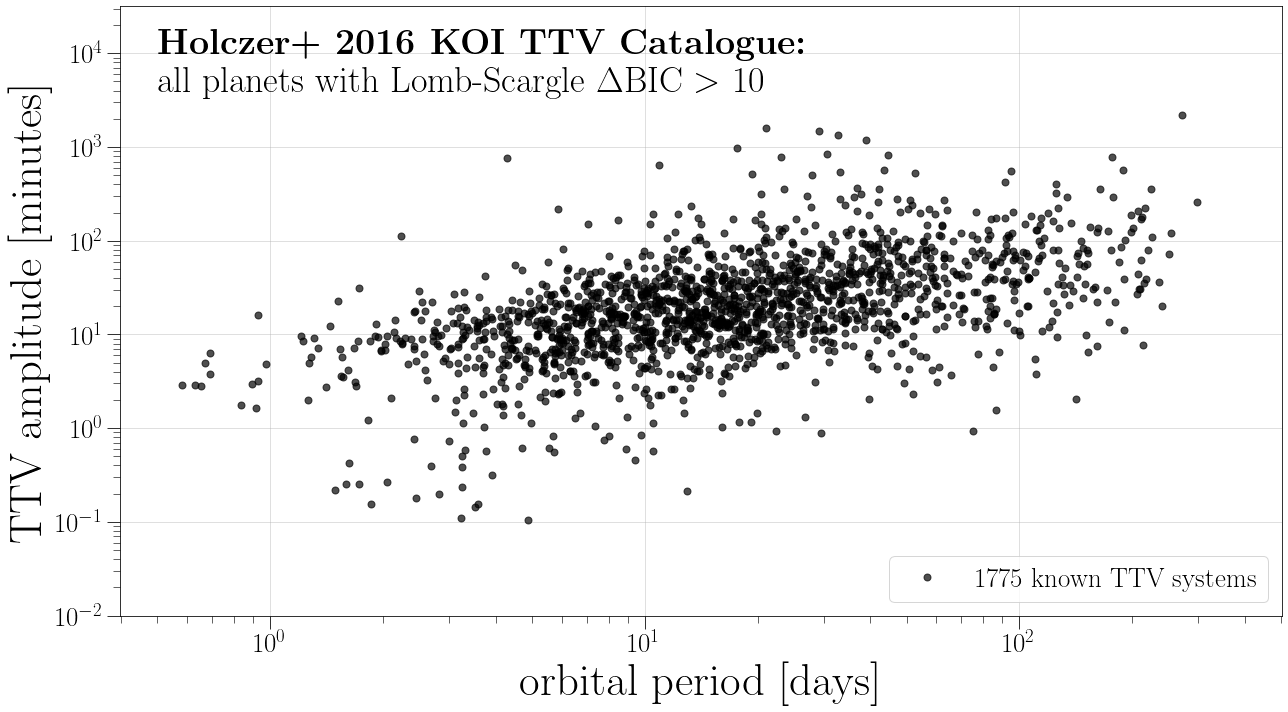

In [44]:
plt.figure(figsize=[18,10])

'''
plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')

plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')

'''
plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')

plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2)


plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_all.pdf')

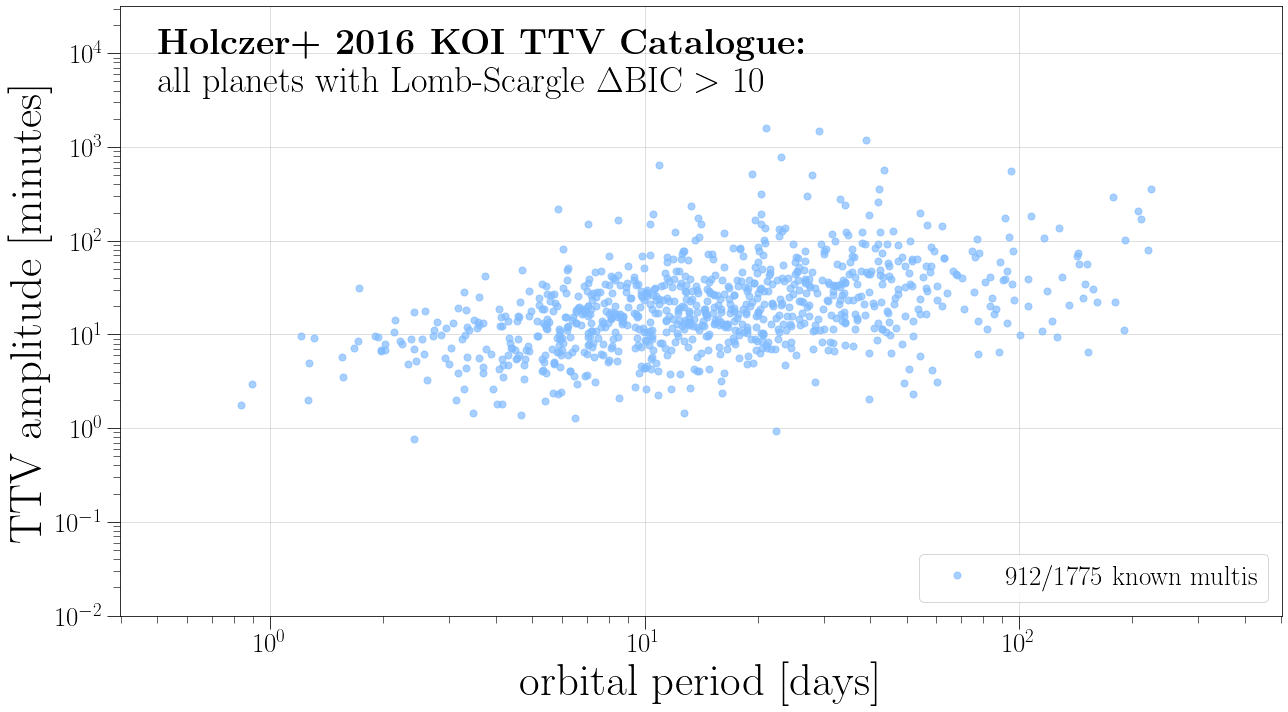

In [45]:
plt.figure(figsize=[18,10])


plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')
'''
plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')


plt.plot(np.log10(np.array(ttv_planets).T[0]), np.log10(np.array(ttv_planets).T[1]), 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')
'''

plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_multis.pdf')

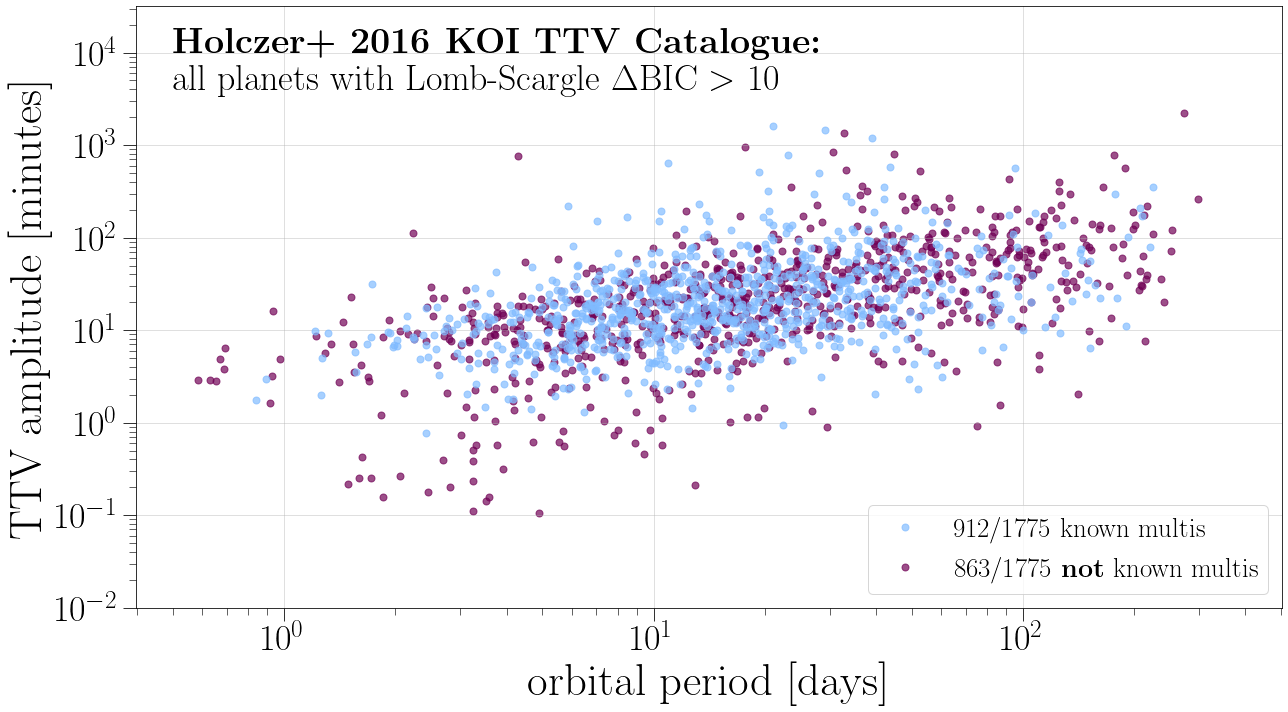

In [46]:

plt.figure(figsize=[18,10])


plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')

plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')

'''
plt.plot(np.log10(np.array(ttv_planets).T[0]), np.log10(np.array(ttv_planets).T[1]), 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')
'''

plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)

plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_singles_vs_multis.pdf')

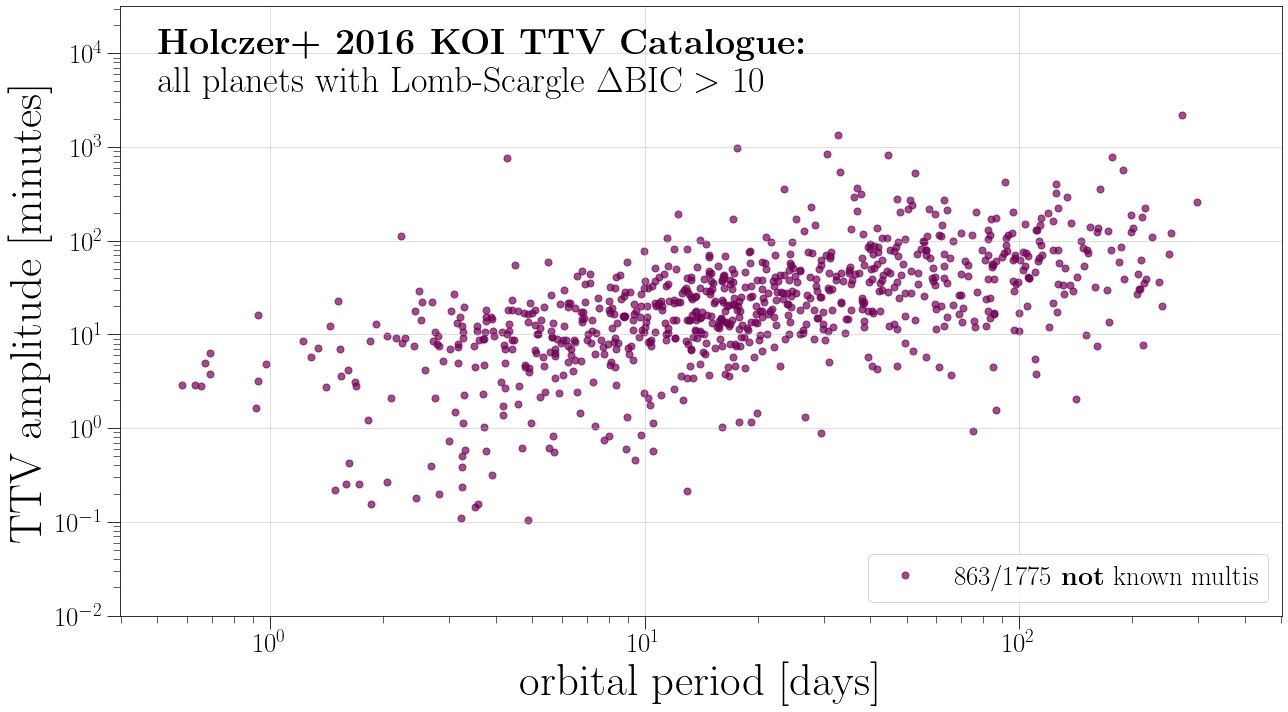

In [47]:
plt.figure(figsize=[18,10])

'''
plt.plot(ttv_multi_planet_periods, ttv_multi_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#80bbff', alpha = .69, zorder=2,
         label = str(len(ttv_multi_planets.T)) + '/' + str(len(ttv_planets)) + ' known multis')
'''

plt.plot(ttv_single_planet_periods, ttv_single_planet_amplitudes, 
         marker = 'o', markersize = '7', ls = '', color = '#700055', alpha = .69, zorder=1,
         label = str(len(ttv_single_planets.T)) + '/' + str(len(ttv_planets)) + r' $\mathbf{not}$ known multis')

'''
plt.plot(np.log10(np.array(ttv_planets).T[0]), np.log10(np.array(ttv_planets).T[1]), 
         marker = 'o', markersize = '7', ls = '', color = 'k', alpha = .69, zorder=2,
         label = str(len(ttv_planets)) + ' known TTV systems')
'''

plt.xlabel(r'orbital period [days]', fontsize=45)
plt.ylabel(r'TTV amplitude [minutes]', fontsize=45)
plt.text(10**(-0.3),10**(4.0),r'\textbf{Holczer+ 2016 KOI TTV Catalogue:}', fontsize=36)
plt.text(10**(-0.3),10**(3.6),'all planets with Lomb-Scargle $\Delta$BIC $>$ 10', fontsize=36)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=27, loc=4)

plt.yscale('log')
plt.xscale('log')

# Increase the size of minor ticks on both x and y axes
plt.tick_params(which='minor', size=7)  # Adjust the size as per your preference
plt.tick_params(which='major', size=13)  # Adjust the size as per your preference

# Turn on the grid
plt.grid(True, alpha=.5)


plt.ylim(10**(-2),10**(4.5))
plt.xlim(10**(-.4),10**(2.7))

plt.tight_layout()

#plt.savefig('holczer_ttvs_singles.pdf')